# Import python libraries

In [14]:
import pyvisa
import sys
import time
import epics
import numpy
import matplotlib.pyplot as plt

# Initialise global variables

In [15]:
MAXF = 16500000000
MINF = 14500000000
MAXP = -14.5
MINP = -20
ai = 0

# Define signal generator communication functions

In [16]:
def setFreq(freq):
    if (freq>MAXF or freq <MINF):
        print('invalid frequency range')
        return False
    inst.write(':FREQ ' + str(freq))
    if (float(inst.query(':FREQ?').strip())==freq):
        return True
    else:
        print(repr(inst.query(':FREQ?')))
        print('failed to set correct frequency')
        return False

def setPow(pow):
    if (pow>MAXP or pow <MINP):
        print('invalid power range')
        return False
    inst.write(':POW ' + str(pow) + 'dBm')
    if (int(inst.query(':POW?').strip())==pow):
        return True
    else:
        print(repr(inst.query(':POW?')))
        print('failed to set correct power')
        return False

def updateFreq():
    current_frequency = readFreq()
    current_increment = readFreqInc()
    if ((current_frequency + current_increment)>MAXF):
        print('invalid frequency range')
        return False
    inst.write(':FREQ UP')
    return True

def updatePow():
    current_power = readPow()
    current_increment = readPowInc()
    if ((current_power+current_increment)>MAXP):
        print('End of power range')
        return False
    inst.write(':POW UP')
    return True

def setFreqInc(inc):
    inst.write(':FREQ:STEP ' + str(inc))
    if (int(inst.query(':FREQ:STEP?').strip())!=inc):
        print('failed to set freq increment')
        return False
    return True

def setPowInc(inc):
    inst.write(':POW:STEP ' + str(inc) + ' dB')
    if (float(inst.query(':POW:STEP?').strip())!=inc):
        print('failed to set increment')
        return False
    return True

def initPnF(freq,power,freqinc,powerinc):
    setFreq(freq)
    setPow(power)
    setFreqInc(freqinc)
    setPowInc(powerinc)

def readFreq():
    return float(inst.query(':FREQ?').strip())

def readPow():
    return float(inst.query(':POW?').strip())

def readFreqInc():
    return float(inst.query(':FREQ:STEP?').strip())

def readPowInc():
    return float(inst.query(':POW:STEP?').strip())
    

def powOn():
    a = readFreq()
    b = readPow()
    if a > MAXF or a < MINF or b > MAXP or b < MINP:
        return False
    inst.write(':OUTP ON')
    return True

def powOff():
    inst.write(':OUTP OFF')

# define functions to interface with IOC

In [17]:
def incAtt():
    global ai
    for i in range(12):
        setAtt(2*i)
        time.sleep(0.2)
        ai=epics.caget("SR00RPA01:IN1_DATA_MONITOR")
        time.sleep(1.5)
        ai = numpy.mean(ai)
        readStat()
        f.write(str(2*i)+"dB:   "+str(ai)+"V\n")

def readStat():
    global ai
    powVal = str(readPow())
    freqVal = str(readFreq())
    attVal = str(epics.caget('car'))
    volVal = str(ai)
    print('Power = ' + powVal + '   Frequency = ' + freqVal + '    Attenuation = ' + attVal + '     Voltage = ' + volVal)

#function to set attenuation
def setAtt(attenVal):
    epics.caput('car', attenVal)

#select switch function
def setSwitch(switchVal):
    if switchVal == 0:
        epics.caput('SR00RPA01:DIGITAL_N5_STATE_CMD','Low' )
    elif switchVal == 1:
        epics.caput('SR00RPA01:DIGITAL_N5_STATE_CMD','High' )

# Set up redpitaya and communication with signal generator

In [18]:
def startSG():
    #set up connection to signal generator
    global rm
    global inst
    rm = pyvisa.ResourceManager()
    inst = rm.open_resource('TCPIP0::192.168.0.254::inst0::INSTR')

    #verifyy connection successful
    if (inst.query('*IDN?')!='ANRITSU,MG3692C,211201,3.62\r\n'):
        sys.exit('unexpected string')
def closeSG():
    global inst
    inst.close()
def startRP():    
    epics.caput('SR00RPA01:IN1_GAIN_CMD', 'Low')
    epics.caput('SR00RPA01:ACQ_TRIGGER_SRC_CMD', 'DISABLED')
    #initialise pins as outputs
    for i in range(6):
                    epics.caput('SR00RPA01:DIGITAL_N'+str(i)+'_DIR_CMD', 'Output')

    #initialise Latch Enable to high
    epics.caput('SR00RPA01:DIGITAL_N4_STATE_CMD', 'High')
    setSwitch(0)
    setAtt(0)

In [19]:
def measureData():
    global ai
    epics.caput('SR00RPA01:START_CONT_ACQ_CMD', '1')
    powOn()
    voltageList = []
    time.sleep(1.5)
    ai=epics.caget("SR00RPA01:IN1_DATA_MONITOR")
    time.sleep(1.5)
    voltageList.append(numpy.mean(ai))
    while updatePow():
        powOn()
        time.sleep(1.5)
        ai=epics.caget("SR00RPA01:IN1_DATA_MONITOR")
        time.sleep(1.5)
        voltageList.append(numpy.mean(ai))
        powOff()
    epics.caput('SR00RPA01:STOP_ACQ_CMD', '1')
    return voltageList

def plot(yaxis):
    plt.plot(list(numpy.arange(-20,-14,0.5)),yaxis,linestyle="dotted")
    plt.xlabel('Power (dBm)')
    plt.ylabel('Voltage (V)')
    plt.show()
    
def runAutomation(freq=14500000000,power=-20,freqinc=100000000,powerinc=0.5):
    startRP()
    startSG()
    initPnF(freq,power,freqinc,powerinc)
    plot(measureData())
    closeSG()
    

# Main. Call functions and read values 

In [341]:
# setSwitch(0)
# setAtt(0)

# initPnF()
# epics.caput('SR00RPA01:START_CONT_ACQ_CMD', '1')
# #run the script
# f = open("autoconfig.txt", "w")

# f.write("Power = " + str(readPow())+'\n')
# f.write("Frequency = " + str(readFreq())+'\n')

# f.write("attenuation, voltage\n")
# incAtt()

# while(updateFreq()):
#     f.write("Frequency = " + str(readFreq())+'\n')
#     f.write("attenuation, voltage\n")
#     powOn()
#     incAtt()
#     powOff()
# setFreq()
# while(updatePow()):
# f.write("Power = " + str(readPow())+'\n')
# while(updateFreq()):
#     f.write("Frequency = " + str(readFreq())+'\n')
#     f.write("attenuation, voltage\n")
#     powOn()
#     incAtt()
#     powOff()
# setFreq()        

# powOff()
# inst.close()
# epics.caput('SR00RPA01:STOP_ACQ_CMD', '1')
# f.close()

# f=open("autoconfig.txt","r")

# print(f.read())

End of power range


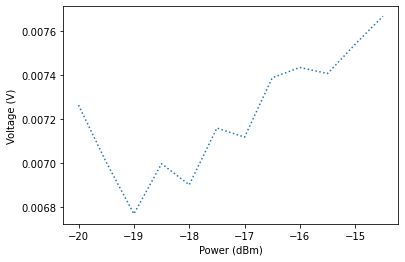

In [346]:
runAutomation(14500000000)

End of power range


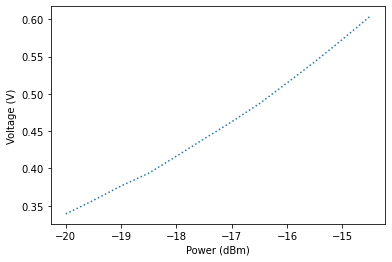

In [347]:
runAutomation(15500000000)

End of power range


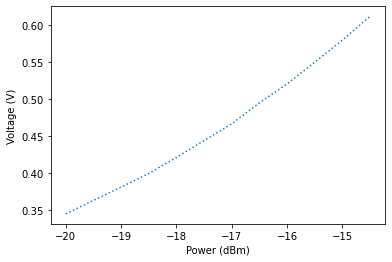

In [348]:
runAutomation(16500000000)